In [1]:
import os
import gym
import torch as T
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from unityagents import UnityEnvironment

In [2]:
class OUActionNoise(object):
    def __init__(self, mu, sigma=0.15, theta=.2,dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()
        
    def __call__(self):
        x = self.x_previous
        dx = self.theta * (self.mu - x) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_previous = x + dx
        return x
    
    def reset(self):
        self.x_previous = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

In [3]:
class ReplayBuffer(object):
    def __init__(self, max_size, inp_shape, nb_actions):
        self.memory_size = max_size
        self.memory_counter = 0
        self.memory_state = np.zeros((self.memory_size, *inp_shape))
        self.new_memory_state = np.zeros((self.memory_size, *inp_shape))
        self.memory_action = np.zeros((self.memory_size, nb_actions))
        self.memory_reward = np.zeros(self.memory_size)
        self.memory_terminal = np.zeros(self.memory_size, dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):
        index = self.memory_counter % self.memory_size
        self.memory_state[index] = state
        self.new_memory_state[index] = state_
        self.memory_action[index] = action
        self.memory_reward[index] = reward
        self.memory_terminal[index] = 1 - done
        self.memory_counter += 1

    def sample_buffer(self, bs):
        max_memory = min(self.memory_counter, self.memory_size)

        batch = np.random.choice(max_memory, bs)

        states = self.memory_state[batch]
        actions = self.memory_action[batch]
        rewards = self.memory_reward[batch]
        states_ = self.new_memory_state[batch]
        terminal = self.memory_terminal[batch]

        return states, actions, rewards, states_, terminal

In [4]:
class CriticNetwork(T.nn.Module):
    def __init__(
        self, beta, inp_dimensions,
        fc1_dimensions, fc2_dimensions,
        nb_actions):
        super(CriticNetwork, self).__init__()
        self.inp_dimensions = inp_dimensions
        self.fc1_dimensions = fc1_dimensions
        self.fc2_dimensions = fc2_dimensions
        self.nb_actions = nb_actions

        self.fc1 = T.nn.Linear(*self.inp_dimensions, self.fc1_dimensions)
        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
        T.nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        T.nn.init.uniform_(self.fc1.bias.data, -f1, f1)

        self.bn1 = T.nn.LayerNorm(self.fc1_dimensions)

        self.fc2 = T.nn.Linear(self.fc1_dimensions, self.fc2_dimensions)
        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])

        T.nn.init.uniform_(self.fc2.weight.data, -f2, f2)
        T.nn.init.uniform_(self.fc2.bias.data, -f2, f2)

        self.bn2 = T.nn.LayerNorm(self.fc2_dimensions)

        self.action_value = T.nn.Linear(self.nb_actions, self.fc2_dimensions)
        f3 = 0.003
        self.q = T.nn.Linear(self.fc2_dimensions, 1)
        T.nn.init.uniform_(self.q.weight.data, -f3, f3)
        T.nn.init.uniform_(self.q.bias.data, -f3, f3)

        self.optimizer = T.optim.Adam(self.parameters(), lr=beta)

        self.device = T.device("gpu" if T.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, state, action):
        state_value = self.fc1(state)
        state_value = self.bn1(state_value)
        state_value = T.nn.functional.relu(state_value)
        state_value = self.fc2(state_value)
        state_value = self.bn2(state_value)

        action_value = T.nn.functional.relu(self.action_value(action))
        state_action_value = T.nn.functional.relu(
            T.add(state_value, action_value))
        state_action_value = self.q(state_action_value)

        return state_action_value

In [5]:
class ActorNetwork(T.nn.Module):
    def __init__(
        self, alpha, inp_dimensions,
        fc1_dimensions, fc2_dimensions,
        nb_actions):
        super(ActorNetwork, self).__init__()
        self.inp_dimensions = inp_dimensions
        self.fc1_dimensions = fc1_dimensions
        self.fc2_dimensions = fc2_dimensions
        self.nb_actions = nb_actions

        self.fc1 = T.nn.Linear(*self.inp_dimensions, self.fc1_dimensions)
        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
        T.nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        T.nn.init.uniform_(self.fc1.bias.data, -f1, f1)

        self.bn1 = T.nn.LayerNorm(self.fc1_dimensions)

        self.fc2 = T.nn.Linear(self.fc1_dimensions, self.fc2_dimensions)
        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])

        T.nn.init.uniform_(self.fc2.weight.data, -f2, f2)
        T.nn.init.uniform_(self.fc2.bias.data, -f2, f2)

        self.bn2 = T.nn.LayerNorm(self.fc2_dimensions)

        f3 = 0.003
        self.mu = T.nn.Linear(self.fc2_dimensions, self.nb_actions)
        T.nn.init.uniform_(self.mu.weight.data, -f3, f3)
        T.nn.init.uniform_(self.mu.bias.data, -f3, f3)

        self.optimizer = T.optim.Adam(self.parameters(), lr=alpha)

        self.device = T.device("gpu" if T.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, state):
        x = self.fc1(state)
        x = self.bn1(x)
        x = T.nn.functional.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = T.nn.functional.relu(x)
        x = T.tanh(self.mu(x))

        return x

In [6]:
class Agent(object):
    def __init__(
        self, alpha, beta, inp_dimensions, tau, env,
        gamma=0.99, nb_actions=2, max_size=1000000,
        l1_size=400, l2_size=300, bs=64):
        self.gamma = gamma
        self.tau = tau
        self.memory = ReplayBuffer(max_size, inp_dimensions, nb_actions)
        self.bs = bs

        self.actor = ActorNetwork(
            alpha, inp_dimensions, l1_size, l2_size, nb_actions=nb_actions)
        self.critic = CriticNetwork(
            beta, inp_dimensions, l1_size, l2_size, nb_actions=nb_actions)
        self.target_actor = ActorNetwork(
            alpha, inp_dimensions, l1_size, l2_size, nb_actions=nb_actions)
        self.target_critic = CriticNetwork(
            beta, inp_dimensions, l1_size, l2_size, nb_actions=nb_actions)

        self.noise = OUActionNoise(mu=np.zeros(nb_actions))

        self.update_params(tau=1)

    def select_action(self, observation):
        self.actor.eval()
        observation = T.tensor(
            observation, dtype=T.float).to(self.actor.device)
        mu = self.actor.forward(observation).to(self.actor.device)
        mu_prime = mu + T.tensor(
            self.noise(),
            dtype=T.float).to(self.actor.device)
        self.actor.train()
        return mu_prime.cpu().detach().numpy()

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def learn(self):
        if self.memory.memory_counter < self.bs:
            return
        state, action, reward, new_state, done = \
                                        self.memory.sample_buffer(self.bs)

        reward = T.tensor(reward, dtype=T.float).to(self.critic.device)
        done = T.tensor(done).to(self.critic.device)
        new_state = T.tensor(new_state, dtype=T.float).to(self.critic.device)
        action = T.tensor(action, dtype=T.float).to(self.critic.device)
        state = T.tensor(state, dtype=T.float).to(self.critic.device)

        self.target_actor.eval()
        self.target_critic.eval()
        self.critic.eval()

        target_actions = self.target_actor.forward(new_state)
        critic_value_new = self.target_critic.forward(
            new_state, target_actions)
        critic_value = self.critic.forward(state, action)

        target = []
        for j in range(self.bs):
            target.append(reward[j] + self.gamma*critic_value_new[j]*done[j])
        target = T.tensor(target).to(self.critic.device)
        target = target.view(self.bs, 1)

        self.critic.train()
        self.critic.optimizer.zero_grad()
        critic_loss = T.nn.functional.mse_loss(target, critic_value)
        critic_loss.backward()
        self.critic.optimizer.step()

        self.critic.eval()
        self.actor.optimizer.zero_grad()
        mu = self.actor.forward(state)
        self.actor.train()
        actor_loss = -self.critic.forward(state, mu)
        actor_loss = T.mean(actor_loss)
        actor_loss.backward()
        self.actor.optimizer.step()

        self.update_params()

    def update_params(self, tau=None):
        if tau is None:
            tau = self.tau # tau is 1

        actor_params = self.actor.named_parameters()
        critic_params = self.critic.named_parameters()
        target_actor_params = self.target_actor.named_parameters()
        target_critic_params = self.target_critic.named_parameters()

        critic_state_dict = dict(critic_params)
        actor_state_dict = dict(actor_params)
        target_critic_dict = dict(target_critic_params)
        target_actor_dict = dict(target_actor_params)

        for name in critic_state_dict:
            critic_state_dict[name] = tau*critic_state_dict[name].clone() + \
                (1-tau)*target_critic_dict[name].clone()

        self.target_critic.load_state_dict(critic_state_dict)

        for name in actor_state_dict:
            actor_state_dict[name] = tau*actor_state_dict[name].clone() + \
                (1-tau)*target_actor_dict[name].clone()
        self.target_actor.load_state_dict(actor_state_dict)

In [7]:
env = UnityEnvironment(file_name='Reacher.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [8]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]

In [9]:
#Reset the Environment
env_info = env.reset(train_mode=True)[brain_name]

#Number of Agents
num_agents = len(env_info.agents)
print('Number of Agents:', num_agents)

#Size of Each Action
action_size = brain.vector_action_space_size
print('Size of Each Action:', action_size)

#Examine the State Space
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} Agents. Each Observes a State with Length: {}'.format(states.shape[0], state_size))
print('The State for the First Agent Looks Like:', states[0])

Number of Agents: 1
Size of Each Action: 4
There are 1 Agents. Each Observes a State with Length: 33
The State for the First Agent Looks Like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -6.30408478e+00 -1.00000000e+00
 -4.92529202e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -5.33014059e-01]


In [10]:

agent = Agent(alpha=0.000025, beta=0.00025, \
              inp_dimensions=[33], tau=0.001, \
              env=env, bs=64, l1_size=400, \
              l2_size=300, nb_actions=4)

num_agents = 1
brain_name = env.brain_names[0]
env_info = env.reset(train_mode=True)[brain_name]
states = env_info.vector_observations
scores = np.zeros(num_agents)
scoresToUse = []
actions = np.random.randn(1, 4)

for x in range(0,100): 
    env_info = env.reset(train_mode=True)[brain_name]
    while True:
        observation=env_info.vector_observations
        actions = agent.select_action(observation)
        actions = np.clip(actions, -1, 1) 
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        scores += env_info.rewards
        states = next_states
        if np.any(dones):
            scoresToUse.append(np.mean(scores))
            break
    print('Total Average Score After {} episodes: {}'.format(x+1, np.mean(scores)))


Total Average Score After 1 episodes: 0.0
Total Average Score After 2 episodes: 1.2099999729543924
Total Average Score After 3 episodes: 1.2099999729543924
Total Average Score After 4 episodes: 1.8299999590963125
Total Average Score After 5 episodes: 3.539999920874834
Total Average Score After 6 episodes: 3.709999917075038
Total Average Score After 7 episodes: 4.009999910369515
Total Average Score After 8 episodes: 4.039999909698963
Total Average Score After 9 episodes: 4.189999906346202
Total Average Score After 10 episodes: 4.469999900087714
Total Average Score After 11 episodes: 5.139999885112047
Total Average Score After 12 episodes: 5.139999885112047
Total Average Score After 13 episodes: 5.579999875277281
Total Average Score After 14 episodes: 5.579999875277281
Total Average Score After 15 episodes: 6.049999864771962
Total Average Score After 16 episodes: 6.409999856725335
Total Average Score After 17 episodes: 6.9999998435378075
Total Average Score After 18 episodes: 7.089999841

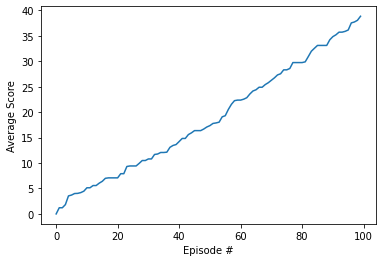

In [11]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scoresToUse)), scoresToUse)
plt.ylabel('Average Score')
plt.xlabel('Episode #')
plt.show() 

In [ ]:
env.close()